# MOAIに関する基礎的な実験

## Contents
 - MOAIとは
 - 実験の目的
 - 実験結果
  - 分枝限定法による整数最適化問題の求解
  - 問題-可能な解のデータセット作成
  - 深層学習モデルによるデータセットの学習
  - 検証
 - 議論を深めるために

## 1. MOAIとは
> MO/AI は Mathematical Optimization/ Artificial Intelligence) の略でモアイと読みます.  

[MOAIフォーラム](https://vagabond-journey-286.notion.site/MOAI-Forum-bad15e6d16984697a4c1871b03af0008)

MOAIは上記のとおり、機械学習と数理最適化の融合分野を指す呼称です。融合により機械学習をenhanceするのか、それとも数理最適化をenhanceするのかによって、さらにいくつかの技術領域に整理されることが知られています[東京海洋大久保教授による講義スライドより下図を引用](https://file.notion.so/f/f/b89f0a20-f54c-4924-a710-8b43fa66b474/4b64a1dc-a1a9-4739-aa88-ea934ab0ea50/unified_model.pdf?id=7c2372e4-f10f-4579-8824-52b0bce62673&table=block&spaceId=b89f0a20-f54c-4924-a710-8b43fa66b474&expirationTimestamp=1722139200000&signature=RsDODxkFPfve3DjHX8IDSDU6xOIhlhpLS_NDBgcu3bw&downloadName=unified_model.pdf)。  

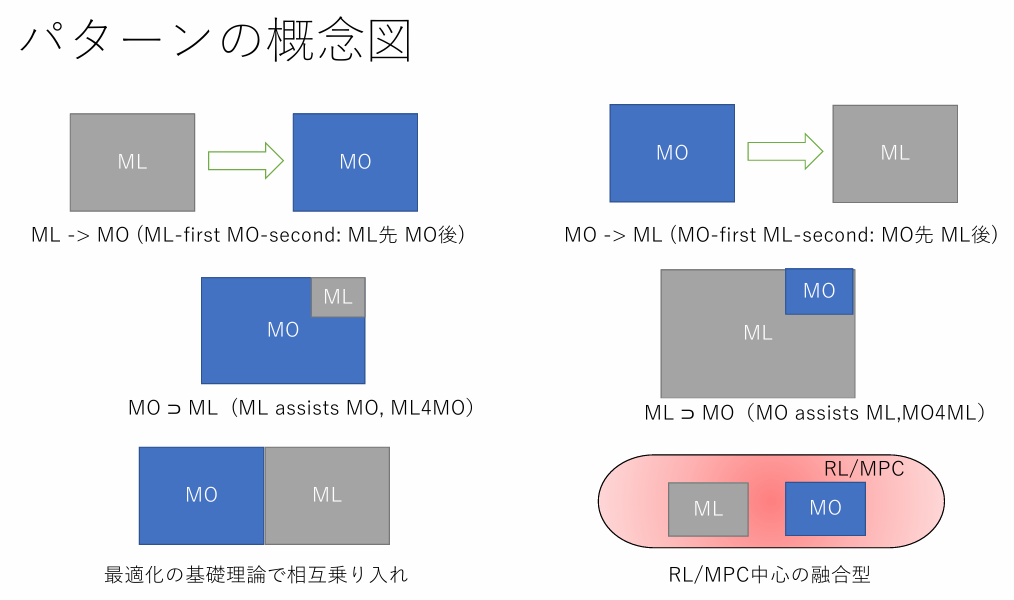  

このうち、パターン1（ML→MO）やパターン4（MO ⊃ ML）は、機械学習を実務に用いる方はかなりの割合で出くわします。例えば、ポリマーの配合比率と目的物性との間で機械学習モデルを構築したのち、目的物性を所望の範囲に収める配合比を最適化アルゴリズムで求めたり、はたまた何等かの機械学習モデルにおけるハイパーパラメータの組合せを、各種最適化アルゴリズムによって自動的に求める、といったケースが挙げられるでしょう。一方で、今回私が着目するのはパターン3（ML4MO）、すなわち数理最適化を何等かの形で機械学習によって効率化するという技術領域です。

引き続き先ほどのスライドを引用します。機械学習を数理最適化に援用する手法としては、多くの問題例を学習したうえで①MLが解の手掛りを返すことで最適化を高速化する（MIPlearn）、②直接MLが解を返す（End-to-End learning）、③MLが近似解（実行不能）を返し、後で実行可能解に変換する（optimization proxy）の大きく3つに分けられます。

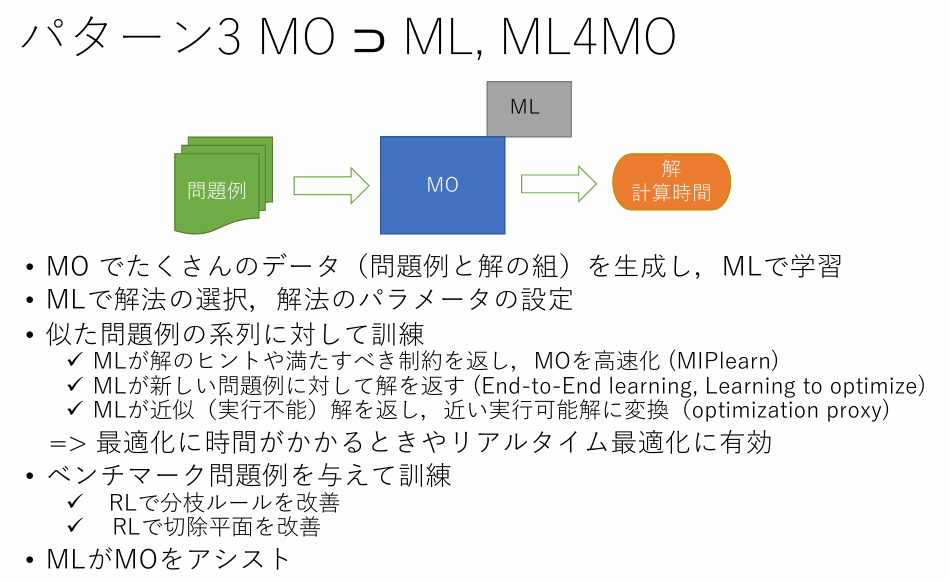

## 2. 今回の目的

今回はML4MOについて、簡単な例を用いて概念検証を行います。具体的には、整数計画問題（線形）を対象としてランダムに問題を生成、これを解くことにより問題の条件(X)と解(y)からなる学習データセットを得ます。問題の求解にあたっては単純な分枝限定法を利用し、また最終的な解だけでなく、各問題について最適化の過程で得られた可能な解の候補を全て学習データに加えます（つまり、一組のXに対して複数のyが存在する）。その後、これらデータセットの関係を機械学習モデルにて学習させ、問題条件Xを入力すれば可能な解候補を（制約条件を満たして）得られるようにすることを目指します。

## 3. 実験結果
### 3-1. 分枝限定法による数理最適化と学習データ作成

初めに、学習に用いるための数理最適化データセットを作成します。今回は簡単のため、30変数、10制約からなる整数計画法の問題を100セット生成しました。分枝限定法はpulpでも使用することができますが、今回は「途中で得られた解も用いる」ことを前提としているため、スクラッチで簡単に実装した分枝限定法のスクリプトを使用しました。

In [2]:
import numpy as np
import pandas as pd
import random
import torch
from queue import PriorityQueue
from sklearn.model_selection import train_test_split

# ノードクラス定義
class Node:
    def __init__(self, level, value, vars, bound, selected_vars, var_order):
        self.level = level
        self.value = value
        self.vars = vars
        self.bound = bound
        self.selected_vars = selected_vars
        self.var_order = var_order

    def __lt__(self, other):
        return self.bound > other.bound  # PriorityQueueは最小値を優先するため、boundの大きい順にする

# 上界の計算関数
def bound(node, c, A, b, c0):
    if np.any(np.dot(A, node.vars) > b):
        return 0
    profit_bound = node.value
    level = node.level + 1

    if level < len(c):
        remaining_capacity = b - np.dot(A, node.vars).astype(float)
        remaining_profit = np.zeros_like(c, dtype=float)

        for j in range(level, len(c)):
            if remaining_capacity.min() <= 0:
                break
            coeffs = A[:, node.var_order[j]].astype(float)
            max_possible = np.min(remaining_capacity / coeffs)
            remaining_profit[node.var_order[j]] = c[node.var_order[j]] * max_possible
            remaining_capacity -= coeffs * max_possible

        profit_bound += np.sum(remaining_profit)

    return profit_bound

# 分枝限定法ワーカー関数（シングルスレッド）
def branch_and_bound_single(problem_index, c, A, b, c0):
    queue = PriorityQueue()
    result_queue = []
    var_order = list(range(len(c)))
    random.shuffle(var_order)  # 変数の順序をランダムにする
    root = Node(-1, c0, np.zeros_like(c), 0.0, [], var_order)
    root.bound = bound(root, c, A, b, c0)
    max_profit = 0
    queue.put(root)

    while not queue.empty():
        node = queue.get()
        if node.level == -1:
            level = 0
        else:
            level = node.level + 1

        if level < len(c):
            new_selected_vars = node.selected_vars + [node.var_order[level]]
            for val in range(0, 10):  # Adjust the range as needed
                left_vars = node.vars.copy()
                left_vars[node.var_order[level]] = val  # Assign an integer value to the variable
                left_node = Node(level, node.value + c[node.var_order[level]] * val, left_vars, 0.0, new_selected_vars, node.var_order)
                if np.all(np.dot(A, left_node.vars) <= b) and left_node.value > max_profit:
                    max_profit = left_node.value
                    result_queue.append({
                        "Problem Index": problem_index,
                        "Profit": left_node.value,
                        "Selected Vars": new_selected_vars,
                        "Vars": left_node.vars.tolist()
                    })
                left_node.bound = bound(left_node, c, A, b, c0)
                if left_node.bound > max_profit:
                    queue.put(left_node)

    return max_profit, result_queue

# データセットの生成
num_problems = 100
num_vars = 30
num_constraints = 10
problems = []

for i in range(num_problems):
    c = np.random.randint(1, 10, num_vars)
    A = np.random.randint(1, 3, (num_constraints, num_vars))
    b = np.random.randint(10, 50, num_constraints)
    c0 = 0  # 定数項
    problems.append((i, c, A, b, c0))

# 各問題を解く
all_results = []
problem_vectors = []

for problem in problems:
    problem_index, c, A, b, c0 = problem
    max_profit, result_queue = branch_and_bound_single(problem_index, c, A, b, c0)
    all_results.extend(result_queue)
    problem_vector = np.concatenate([c.flatten(), A.flatten(), b.flatten(), np.array([c0])])
    problem_vectors.extend([problem_vector] * len(result_queue))

# 結果のデータフレームを作成
results_df = pd.DataFrame(all_results)
problem_vectors_df = pd.DataFrame(problem_vectors)

# インデックスを含めて保存
y_df = results_df[['Vars', 'Profit']].reset_index()
x_df = problem_vectors_df.reset_index()

# データの保存
y_df.to_csv('y_values.csv', index=False)
x_df.to_csv('x_values.csv', index=False)

print(y_df.head())
print(x_df.head())


   index                                               Vars  Profit
0      0  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...       7
1      1  [0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, ...      14
2      2  [0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, ...      21
3      3  [0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, ...      28
4      4  [0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, ...      35
   index  0  1  2  3  4  5  6  7  8  ...  331  332  333  334  335  336  337  \
0      0  4  3  2  8  8  8  8  7  7  ...   11   45   23   25   20   11   43   
1      1  4  3  2  8  8  8  8  7  7  ...   11   45   23   25   20   11   43   
2      2  4  3  2  8  8  8  8  7  7  ...   11   45   23   25   20   11   43   
3      3  4  3  2  8  8  8  8  7  7  ...   11   45   23   25   20   11   43   
4      4  4  3  2  8  8  8  8  7  7  ...   11   45   23   25   20   11   43   

   338  339  340  
0   10   34    0  
1   10   34    0  
2   10   34    0  
3   10   34    0  
4   10   34    0  

[5

作成したデータセットに対して、念のため「得られた解が各問題の制約条件を満たしているか」を確認します。

In [4]:
import numpy as np
import json

def check_constraints(y_row, x_row, num_vars, num_constraints):
    # y_rowから解を取得
    vars_solution = np.array(y_row['Vars'])
    
    # x_rowから制約を取得
    c_length = num_vars
    A_start = c_length
    A_end = A_start + (num_constraints * num_vars)
    b_start = A_end
    b_end = b_start + num_constraints

    c = x_row[1:c_length+1].values
    A = x_row[c_length+1:A_end+1].values.reshape(num_constraints, num_vars)
    b = x_row[A_end+1:b_end+1].values

    # 制約を検証
    return np.all(np.dot(A, vars_solution) <= b)


# 使用例
y_example = y_df.iloc[0]
x_example = x_df.iloc[0]

is_valid = check_constraints(y_example, x_example, num_vars=30, num_constraints=10)
print(f'Constraints satisfied: {is_valid}')


Constraints satisfied: True


### 3-2. 深層学習モデルによる数理最適化問題の学習

続いて深層学習モデルによる学習を行うため、データセットを整理します。

In [5]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split

# データをトレーニングセットとテストセットに分割
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=42)

# y_train と y_test の 'Vars' 列をリストから数値型に変換
def flatten_vars(df):
    return np.array([np.concatenate((row['Vars'], [row['Profit']])) for _, row in df.iterrows()])

y_train_flat = flatten_vars(y_train)
y_test_flat = flatten_vars(y_test)

# 最後の列を削除する関数
def remove_last_column(array):
    return array[:, :-1]

# 最後の列を削除
y_train_flat = remove_last_column(y_train_flat)
y_test_flat = remove_last_column(y_test_flat)

# データを torch.Tensor に変換
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_flat, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_flat, dtype=torch.float32)

print(X_train_tensor.shape)
print(y_train_tensor.shape)
print(X_test_tensor.shape)
print(y_test_tensor.shape)


torch.Size([1048, 342])
torch.Size([1048, 30])
torch.Size([262, 342])
torch.Size([262, 30])


In [27]:
y_train_tensor[10]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 9., 0., 0.,
        0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [6]:

# GPUが利用可能かどうかを確認
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# データをGPUに移動
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

In [7]:
# 商品データフレーム、制約データフレーム、結果データフレームを表示
print("X_train_tensor.shape:", X_train_tensor.shape)
print("y_train_tensor.shape:", y_train_tensor.shape)
print("X_test_tensor.shape:", X_test_tensor.shape)
print("y_test_tensor.shape:", y_test_tensor.shape)

X_train_tensor.shape: torch.Size([1048, 342])
y_train_tensor.shape: torch.Size([1048, 30])
X_test_tensor.shape: torch.Size([262, 342])
y_test_tensor.shape: torch.Size([262, 30])


ニューラルネットワークを定義します。今回は入力を一度次元削減したのち、再度次元を増やすというVAEライクなネットワークを用いました。

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

# デバイスの設定（CPUまたはGPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ネットワークの定義
class LatentNN(nn.Module):
    def __init__(self, input_dim, latent_dim, output_dim):
        super(LatentNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        output = self.decoder(z)
        return output

# ハイパーパラメータの設定
input_dim = X_train_tensor.shape[1]
latent_dim = 128  # 潜在空間の次元
output_dim = y_train_tensor.shape[1]
learning_rate = 0.001
num_epochs = 2000

# モデル、損失関数、最適化手法の定義
model = LatentNN(input_dim, latent_dim, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# データをデバイスに移動
X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)



In [13]:
# check_constraints関数の再定義
def check_constraints(y_vars, x_row_np, num_vars, num_constraints):
    # y_varsが解として与えられる
    vars_solution = np.array(y_vars)
    
    # x_row_npから制約を取得
    c_length = num_vars
    A_start = c_length
    A_end = A_start + (num_constraints * num_vars)
    b_start = A_end
    b_end = b_start + num_constraints

    c = x_row_np[:c_length]
    A = x_row_np[c_length:A_end].reshape(num_constraints, num_vars)
    b = x_row_np[A_end:b_end]

    # 制約を検証
    return np.all(np.dot(A, vars_solution) <= b)

ニューラルネットワークの学習に用いる損失関数を定義します。通常損失関数には、最終的な出力とyとのMSEに代表される誤差を用います。しかし今回は、データセットが数理最適化問題であることを考慮し「制約条件に対する違反量」に定数をかけた値を別途損失関数として定義し、backwardの際に双方を対象とするという工夫を行いました。

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim

# 制約違反量を計算する関数
def constraint_violation_amount(outputs, X_tensor, num_vars, num_constraints):
    c_length = num_vars
    A_start = c_length
    A_end = A_start + (num_constraints * num_vars)
    b_start = A_end
    b_end = b_start + num_constraints

    A = X_tensor[:, A_start:A_end].reshape(-1, num_constraints, num_vars)
    b = X_tensor[:, A_end:b_end]

    violations = torch.matmul(A, outputs.unsqueeze(-1)).squeeze(-1) - b
    violations[violations < 0] = 0  # 満たしている場合は違反量を0にする
    total_penalty = violations.sum()
    
    return total_penalty

# モデル、損失関数、最適化手法の定義
base_loss = nn.MSELoss()
penalty_weight = 0.01  # ペナルティの重みを調整
model = LatentNN(input_dim, latent_dim, output_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


学習を行います。学習の進行に伴いlossが減少する様子が見て取れました。

In [19]:
# データをデバイスに移動
X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

num_epochs = 30000

# トレーニング
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(X_train_tensor)
    
    # MSEの損失とバックプロパゲーション
    mse_loss = base_loss(outputs, y_train_tensor)
    mse_loss.backward(retain_graph=True)
    
    # ペナルティの損失とバックプロパゲーション
    penalty = constraint_violation_amount(outputs, X_train_tensor, num_vars, num_constraints)
    (penalty_weight * penalty).backward()
    
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        total_loss = mse_loss.item() + penalty_weight * penalty.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss:.4f}, MSE Loss: {mse_loss.item():.4f}, Penalty: {penalty.item():.4f}')

# テスト
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    mse_test_loss = base_loss(y_pred, y_test_tensor)
    penalty_test = constraint_violation_amount(y_pred, X_test_tensor, num_vars, num_constraints)
    total_test_loss = mse_test_loss.item() + penalty_weight * penalty_test.item()
    print(f'Test Total Loss: {total_test_loss:.4f}, MSE Loss: {mse_test_loss.item():.4f}, Penalty: {penalty_test.item():.4f}')


Epoch [10/30000], Total Loss: 1.7454, MSE Loss: 1.7454, Penalty: 0.0000
Epoch [20/30000], Total Loss: 1.3513, MSE Loss: 1.3513, Penalty: 0.0000
Epoch [30/30000], Total Loss: 1.4724, MSE Loss: 1.4724, Penalty: 0.0000
Epoch [40/30000], Total Loss: 6.9887, MSE Loss: 6.9887, Penalty: 0.0000
Epoch [50/30000], Total Loss: 2.6568, MSE Loss: 2.6568, Penalty: 0.0000
Epoch [60/30000], Total Loss: 1.4340, MSE Loss: 1.4340, Penalty: 0.0000
Epoch [70/30000], Total Loss: 2.5581, MSE Loss: 2.5581, Penalty: 0.0000
Epoch [80/30000], Total Loss: 1.9812, MSE Loss: 1.9812, Penalty: 0.0000
Epoch [90/30000], Total Loss: 2.5291, MSE Loss: 2.5291, Penalty: 0.0000
Epoch [100/30000], Total Loss: 4.0016, MSE Loss: 4.0016, Penalty: 0.0000
Epoch [110/30000], Total Loss: 1.9692, MSE Loss: 1.9692, Penalty: 0.0000
Epoch [120/30000], Total Loss: 1.2657, MSE Loss: 1.2657, Penalty: 0.0000
Epoch [130/30000], Total Loss: 1.2214, MSE Loss: 1.2214, Penalty: 0.0000
Epoch [140/30000], Total Loss: 1.2651, MSE Loss: 1.2020, Pen

In [26]:
y_pred[10].round()

tensor([-1., -0., -0., -0., -0., -0., -0., -0.,  0., -0., -0., -0., -0., -0.,
        -0., -0., -0.,  1., -0.,  0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0.,  5.], device='cuda:0')

テストデータに対する予測結果に対し、制約条件を守れているかを調べました。緩和した状態（y_predを整数化しない状態）であれば制約が守られていました。一方で、整数化すると遵守率が低下したので、ここは課題です。

In [22]:
# y_predをNumPy配列に変換
y_pred_np = y_pred.cpu().numpy()

# X_test_tensorの各行をNumPy配列に変換して制約を確認
num_vars = 30
num_constraints = 10

# 制約を満たすか確認するためのループ
for i in range(len(y_pred_np)):
    y_vars = y_pred_np[i]
    x_row_tensor = X_test_tensor[i]
    x_row_np = x_row_tensor.cpu().numpy()
    is_valid = check_constraints(y_vars, x_row_np, num_vars, num_constraints)
    print(f'Prediction {i}: Constraints satisfied: {is_valid}')

Prediction 0: Constraints satisfied: True
Prediction 1: Constraints satisfied: True
Prediction 2: Constraints satisfied: True
Prediction 3: Constraints satisfied: True
Prediction 4: Constraints satisfied: True
Prediction 5: Constraints satisfied: True
Prediction 6: Constraints satisfied: True
Prediction 7: Constraints satisfied: True
Prediction 8: Constraints satisfied: True
Prediction 9: Constraints satisfied: True
Prediction 10: Constraints satisfied: True
Prediction 11: Constraints satisfied: True
Prediction 12: Constraints satisfied: True
Prediction 13: Constraints satisfied: True
Prediction 14: Constraints satisfied: True
Prediction 15: Constraints satisfied: True
Prediction 16: Constraints satisfied: True
Prediction 17: Constraints satisfied: True
Prediction 18: Constraints satisfied: True
Prediction 19: Constraints satisfied: True
Prediction 20: Constraints satisfied: True
Prediction 21: Constraints satisfied: True
Prediction 22: Constraints satisfied: True
Prediction 23: Constr

以下、整数にした状態で制約を守らせる実験…

In [74]:
import torch
import torch.nn as nn
import torch.optim as optim

# 制約違反量を計算する関数
def constraint_violation_amount(outputs, X_tensor, num_vars, num_constraints):
    c_length = num_vars
    A_start = c_length
    A_end = A_start + (num_constraints * num_vars)
    b_start = A_end
    b_end = b_start + num_constraints
    X_tensor = X_tensor.round()

    A = X_tensor[:, A_start:A_end].reshape(-1, num_constraints, num_vars)
    b = X_tensor[:, A_end:b_end]

    violations = torch.matmul(A, outputs.unsqueeze(-1)).squeeze(-1) - b
    violations[violations < 0] = 0  # 満たしている場合は違反量を0にする
    total_penalty = violations.sum()
    
    return total_penalty

# モデル、損失関数、最適化手法の定義
base_loss = nn.MSELoss()
penalty_weight = 0.01  # 初期のペナルティの重み
model = LatentNN(input_dim, latent_dim, output_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# データをデバイスに移動
X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

num_epochs = 30000
threshold_reached = False

# トレーニング
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(X_train_tensor)
    
    # MSEの損失とバックプロパゲーション
    mse_loss = base_loss(outputs, y_train_tensor)
    mse_loss.backward(retain_graph=True)
    
    # ペナルティの損失とスケジューリング
    penalty = constraint_violation_amount(outputs, X_train_tensor, num_vars, num_constraints)
    
    # スケジューリング: MSE損失が一定値より小さくなったら、フラグをセット
    if mse_loss.item() < 0.3:
        scaled_penalty = penalty * (mse_loss.item() / penalty.item() if penalty.item() > 0 else 1.0)
        scaled_penalty.backward()
    else:
        scaled_penalty = penalty
    
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        total_loss = mse_loss.item() + penalty_weight * penalty.item() if not threshold_reached else mse_loss.item() + scaled_penalty.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], MSE Loss: {mse_loss.item():.4f}, Penalty: {penalty.item():.4f}, Scaled Penalty: {scaled_penalty.item():.4f}')

# テスト
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    mse_test_loss = base_loss(y_pred, y_test_tensor)
    penalty_test = constraint_violation_amount(y_pred, X_test_tensor, num_vars, num_constraints)
    scaled_penalty_test = penalty_test * (mse_test_loss.item() / penalty_test.item() if penalty_test.item() > 0 else 1.0)
    total_test_loss = mse_test_loss + scaled_penalty_test
    print(f'Test Total Loss: {total_test_loss:.4f}, MSE Loss: {mse_test_loss.item():.4f}, Penalty: {penalty_test.item():.4f}, Scaled Penalty: {scaled_penalty_test.item():.4f}')


Epoch [10/30000], MSE Loss: 1.1917, Penalty: 9117.8320, Scaled Penalty: 9117.8320
Epoch [20/30000], MSE Loss: 1.1322, Penalty: 8604.9121, Scaled Penalty: 8604.9121
Epoch [30/30000], MSE Loss: 1.0938, Penalty: 7676.2583, Scaled Penalty: 7676.2583
Epoch [40/30000], MSE Loss: 1.0537, Penalty: 8599.3818, Scaled Penalty: 8599.3818
Epoch [50/30000], MSE Loss: 1.0076, Penalty: 8245.7822, Scaled Penalty: 8245.7822
Epoch [60/30000], MSE Loss: 0.9612, Penalty: 8437.3945, Scaled Penalty: 8437.3945
Epoch [70/30000], MSE Loss: 0.9188, Penalty: 8497.5010, Scaled Penalty: 8497.5010
Epoch [80/30000], MSE Loss: 0.8826, Penalty: 8705.0967, Scaled Penalty: 8705.0967
Epoch [90/30000], MSE Loss: 0.8491, Penalty: 8506.7891, Scaled Penalty: 8506.7891
Epoch [100/30000], MSE Loss: 0.8198, Penalty: 8656.7793, Scaled Penalty: 8656.7793
Epoch [110/30000], MSE Loss: 0.7972, Penalty: 8755.1621, Scaled Penalty: 8755.1621
Epoch [120/30000], MSE Loss: 0.7746, Penalty: 8435.6016, Scaled Penalty: 8435.6016
Epoch [130/30

In [77]:
y_pred[5].round()

tensor([-0., 0., -0., -0., -0., -0., -0., 0., -0., -0., 0., 0., -0., -0., 1., 0., -0., -0.,
        -0., -0., 0., -0., 0., -0., -0., 0., -0., 0., -0., -0.],
       device='cuda:0')

In [76]:
# y_predをNumPy配列に変換
y_pred_np = y_pred.cpu().numpy()

# X_test_tensorの各行をNumPy配列に変換して制約を確認
num_vars = 30
num_constraints = 10

# 制約を満たすか確認するためのループ
for i in range(len(y_pred_np)):
    y_vars = y_pred_np[i].round()
    x_row_tensor = X_test_tensor[i]
    x_row_np = x_row_tensor.cpu().numpy()
    is_valid = check_constraints(y_vars, x_row_np, num_vars, num_constraints)
    print(f'Prediction {i}: Constraints satisfied: {is_valid}')

Prediction 0: Constraints satisfied: False
Prediction 1: Constraints satisfied: False
Prediction 2: Constraints satisfied: False
Prediction 3: Constraints satisfied: False
Prediction 4: Constraints satisfied: False
Prediction 5: Constraints satisfied: True
Prediction 6: Constraints satisfied: False
Prediction 7: Constraints satisfied: False
Prediction 8: Constraints satisfied: False
Prediction 9: Constraints satisfied: False
Prediction 10: Constraints satisfied: False
Prediction 11: Constraints satisfied: False
Prediction 12: Constraints satisfied: False
Prediction 13: Constraints satisfied: True
Prediction 14: Constraints satisfied: False
Prediction 15: Constraints satisfied: False
Prediction 16: Constraints satisfied: False
Prediction 17: Constraints satisfied: False
Prediction 18: Constraints satisfied: False
Prediction 19: Constraints satisfied: False
Prediction 20: Constraints satisfied: False
Prediction 21: Constraints satisfied: False
Prediction 22: Constraints satisfied: False
